In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

linear2db = lambda x: 10*np.log10(x) 
db2linear = lambda x: np.power(10,x/10)

In [42]:
class antenna:
    def __init__(self, λ, d, N, w, shift = 0):
        self.λ = λ            # Wave length
        self.d = d            # Distance between 2 antennas
        self.N = N            # Num of antennas in the array
        self.w = w            # Weights by hamming
        self.shift = shift
        
    def GetGain(self, db = True, shift = None, oneSide = False):
        k = 2 * np.pi / np.abs(self.λ)
        locations = np.arange(self.N) * self.d
        
        samples = 360
        gain = np.zeros(samples)
        phis = np.linspace(0,2*np.pi,samples)
        
        if shift:
            beta = np.arange(self.N) * np.deg2rad(shift)
        else:
            beta = np.arange(self.N) * np.deg2rad(self.shift)
        
        for index, phi in enumerate(phis):
            gain[index] = np.sum(self.w * np.exp(1j * beta) * np.exp(locations * -1j * k * np.sin(phi))) #Compute per phi
            
            
        if db:
            gain = linear2db(np.abs(gain) ** 2) # Convert to db and the antenna power
        else:
            gain = np.abs(gain) ** 2
            
        if oneSide:
            gain[90:270] = np.min(gain)
    
        return np.clip(gain,-np.inf,np.inf)     # Boundaries


    def GetBeamWidth(self):
        gain = np.roll(self.GetGain(shift = 0, db = False),180)
        hp = np.max(gain) / 2
        
        r = len(gain)//2
        l = r-1
        
        while gain[l] >= hp and gain[r] >= hp:
            r, l = r+1, l-1 
                
        return np.abs(r - l)
    
    
    def GetBWFN(self, rad = True):
    # The output is in degrees! not radian!
    
        gain = self.GetGain(db = False, oneSide = True)
        imax = np.argmax(gain)
        
        i = imax +1 
        
        while gain[i] > gain[i+1]:
            i += 1
        
        return [imax- i, i]


λ = 1                 # Wave length
N = 2**4              # Num of antennas in the array
shift = 40            # Phase shift in degrees

Antenna1 = antenna(λ = λ, d = λ     , N = N, w = np.hamming(N), shift = shift)
Antenna2 = antenna(λ = λ, d = λ*0.75, N = N, w = np.hamming(N), shift = shift)
Antenna3 = antenna(λ = λ, d = λ*0.5 , N = N, w = np.hamming(N), shift = shift)
Antenna4 = antenna(λ = λ, d = λ*0.25, N = N, w = np.hamming(N), shift = shift)

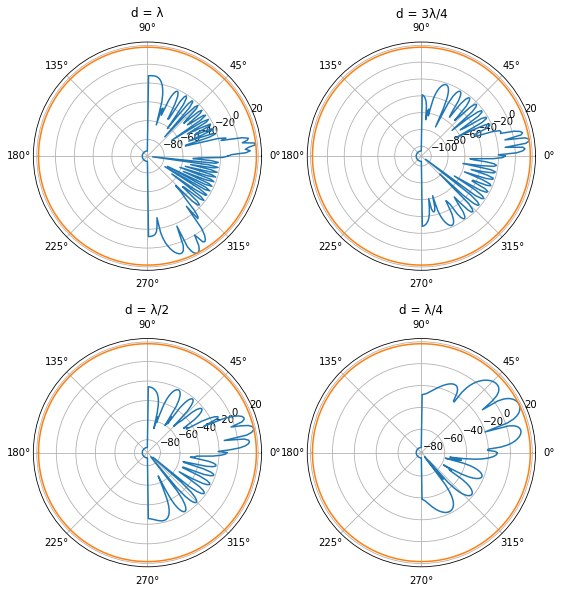

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,10) ,subplot_kw={'projection': 'polar'})  

axs[0, 0].set_title("d = λ")
axs[0, 1].set_title("d = 3λ/4")
axs[1, 0].set_title("d = λ/2")
axs[1, 1].set_title("d = λ/4")

axs[0, 0].plot(np.linspace(0,2*np.pi,360),Antenna1.GetGain(oneSide = True))
axs[0, 1].plot(np.linspace(0,2*np.pi,360),Antenna2.GetGain(oneSide = True))
axs[1, 0].plot(np.linspace(0,2*np.pi,360),Antenna3.GetGain(oneSide = True))
axs[1, 1].plot(np.linspace(0,2*np.pi,360),Antenna4.GetGain(oneSide = True))

axs[0, 0].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna1.GetGain(oneSide = True))))
axs[0, 1].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna2.GetGain(oneSide = True))))
axs[1, 0].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna3.GetGain(oneSide = True))))
axs[1, 1].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna4.GetGain(oneSide = True))))

plt.show()

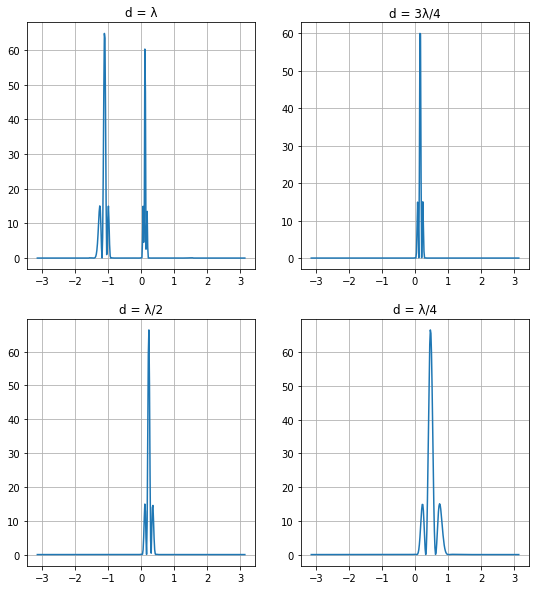

In [44]:
# Plot without shifting just to see the sidelobes

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,10))

axs[0, 0].set_title("d = λ")
axs[0, 1].set_title("d = 3λ/4")
axs[1, 0].set_title("d = λ/2")
axs[1, 1].set_title("d = λ/4")

for i in range(4):
    axs[i%2,i//2].grid()

axs[0, 0].plot(np.linspace(-np.pi,np.pi,360),np.roll(Antenna1.GetGain(oneSide = True, db = False),180))
axs[0, 1].plot(np.linspace(-np.pi,np.pi,360),np.roll(Antenna2.GetGain(oneSide = True, db = False),180))
axs[1, 0].plot(np.linspace(-np.pi,np.pi,360),np.roll(Antenna3.GetGain(oneSide = True, db = False),180))
axs[1, 1].plot(np.linspace(-np.pi,np.pi,360),np.roll(Antenna4.GetGain(oneSide = True, db = False),180))

'''
axs[0, 0].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna1.GetGain(oneSide = True, db = False))))
axs[0, 1].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna2.GetGain(oneSide = True, db = False))))
axs[1, 0].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna3.GetGain(oneSide = True, db = False))))
axs[1, 1].plot(np.linspace(-np.pi,np.pi,360),np.full(360,np.max(Antenna4.GetGain(oneSide = True, db = False))))
'''

'''
axs[0, 0].axvline(x = Antenna1.GetBWFN(side = 'left'), color = 'r',linestyle='--')
axs[0, 1].axvline(x = Antenna2.GetBWFN(side = 'left'), color = 'r',linestyle='--')
axs[1, 0].axvline(x = Antenna3.GetBWFN(side = 'left'), color = 'r',linestyle='--')
axs[1, 1].axvline(x = Antenna4.GetBWFN(side = 'left'), color = 'r',linestyle='--')

axs[0, 0].axvline(x = Antenna1.GetBWFN(side = 'right'), color = 'r',linestyle='--')
axs[0, 1].axvline(x = Antenna2.GetBWFN(side = 'right'), color = 'r',linestyle='--')
axs[1, 0].axvline(x = Antenna3.GetBWFN(side = 'right'), color = 'r',linestyle='--')
axs[1, 1].axvline(x = Antenna4.GetBWFN(side = 'right'), color = 'r',linestyle='--')
'''

Antenna1.GetBWFN()
Antenna2.GetBWFN()
Antenna3.GetBWFN()
Antenna4.GetBWFN()

#axs[0, 0].axvline(x = np.deg2rad(180) - Antenna1.GetBWFN(), color = 'r',linestyle='--')
#axs[0, 1].axvline(x = np.deg2rad(180) - Antenna2.GetBWFN(), color = 'r',linestyle='--')
#axs[1, 0].axvline(x = np.deg2rad(180) - Antenna3.GetBWFN(), color = 'r',linestyle='--')
#axs[1, 1].axvline(x = np.deg2rad(180) - Antenna4.GetBWFN(), color = 'r',linestyle='--')

plt.show()

__Compute the beamwidth:__
* In uniform weights: $\theta = 2 \sin^{-1} \left(\frac{\lambda}{Nd}\right)$ <br/><br/>
* In non-uniform weights: $ \theta = 2\cos^{-1}\left[\frac{\sum\limits_{i=1}^{N} w_i e^{j\phi_i}}{\sum\limits_{i=1}^{N} w_i}\right] $ <br/><br/>
* $ \frac{70 \lambda}{D}$

<br/><br/>
When $\beta = \sin^{-1} \left(\frac{\lambda  k_1}{Nd}\right),  k_1 \in \mathbb{Z}$ the gain is 0 (linear one)

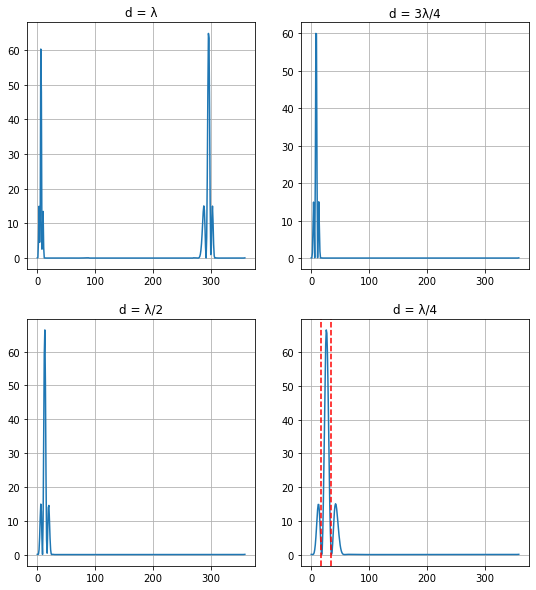

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,10))

axs[0, 0].set_title("d = λ")
axs[0, 1].set_title("d = 3λ/4")
axs[1, 0].set_title("d = λ/2")
axs[1, 1].set_title("d = λ/4")

for i in range(4):
    axs[i%2,i//2].grid()

axs[0, 0].plot(Antenna1.GetGain(oneSide = True, db = False))
axs[0, 1].plot(Antenna2.GetGain(oneSide = True, db = False))
axs[1, 0].plot(Antenna3.GetGain(oneSide = True, db = False))
axs[1, 1].plot(Antenna4.GetGain(oneSide = True, db = False))

gain4 = Antenna4.GetGain(oneSide = True, db = False)
argmax4 = np.argmax(gain4)

#axs[0, 0].axvline(x = np.argmax(Antenna1.GetGain(oneSide = True, db = False)), color = 'r',linestyle='--')
#axs[0, 1].axvline(x = np.argmax(Antenna2.GetGain(oneSide = True, db = False)), color = 'r',linestyle='--')
#axs[1, 0].axvline(x = np.argmax(Antenna3.GetGain(oneSide = True, db = False)), color = 'r',linestyle='--')

i = argmax4
while gain4[i] > gain4[i+1]:
    i += 1
i = i -argmax4
axs[1, 1].axvline(x = argmax4 + i, color = 'r',linestyle='--')
axs[1, 1].axvline(x = argmax4 - i, color = 'r',linestyle='--')

plt.show()